### Parallel Programming Practical 2023-2024

# Implementing Conway's game of life in Julia

by F. Verdugo (VU Amsterdam)

In this notebook, we are going to give some hints about the serial and parallel implementation of Conway's game of life in Julia.





## Description of the algorithm

[Conway's game of life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) is a simple [cell automation](https://en.wikipedia.org/wiki/Cellular_automaton) model. Cells are arranged in a Cartesian 2D grid, each cell having 2 possible states: either live or dead. A set of rules (see below) is applied to update the states at each time step. The game results in simulations like this one:


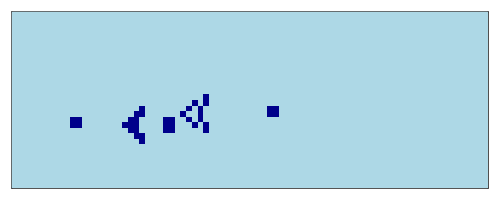

### Game rules

The game has 4 rules (from Wikipedia):

1. Any live cell with fewer than two live neighbors dies, as if by underpopulation.
2. Any live cell with two or three live neighbors lives on to the next generation.
3. Any live cell with more than three live neighbors dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.

In the next figure, you find the rules applied to the center cell of a 3-by-3 grid in different configurations. Grey color indicates a live cell and white a dead one.


 <div>
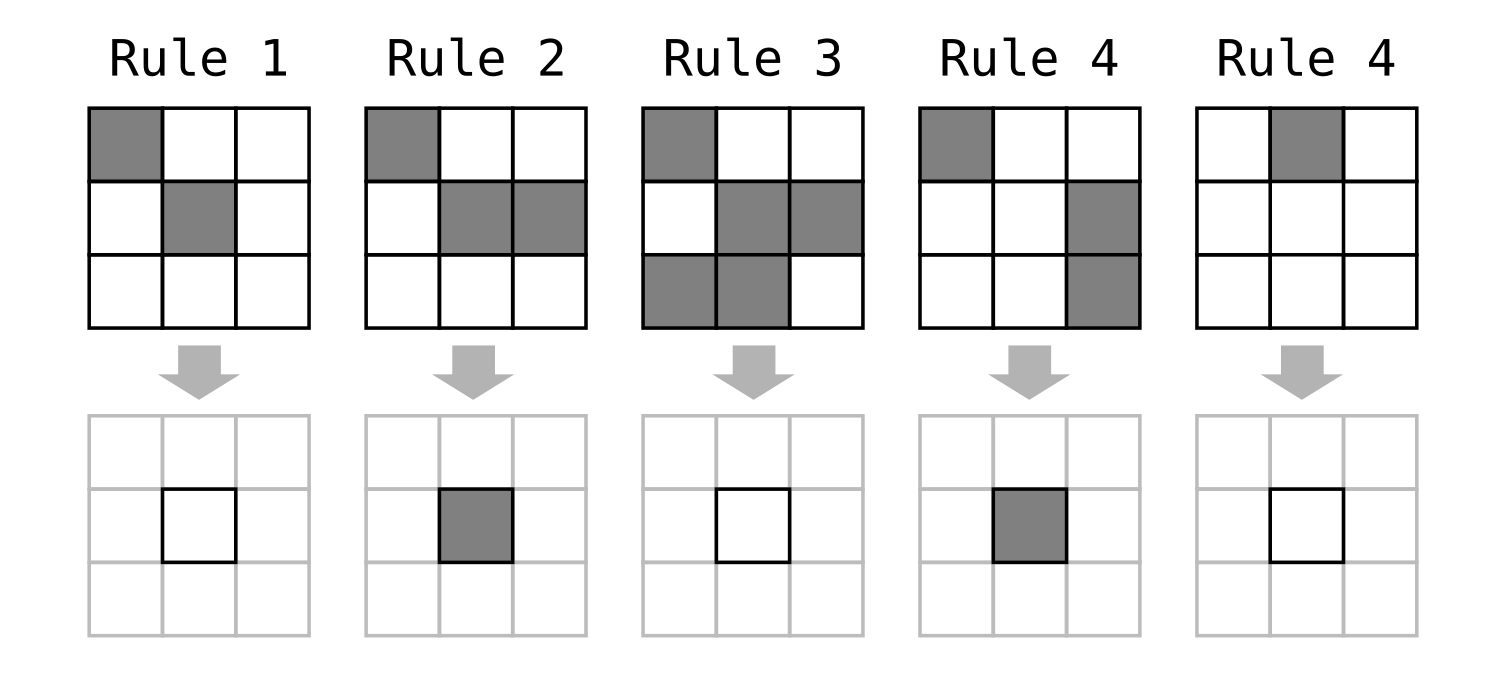
</div>


### Boundary conditions

The rules above are only defined for cells in the interior of the grid. For the cells at the boundary, some neighbors will not be defined (they will correspond to cells outside the grid). In order to deal with boundary cells, we will take the neighbors outside the grid from the other end of the array. These are called periodic boundary conditions. Each cell has 8 neighbors, marked with the sky directions, north, south, east, west, north east, north west, south east, and south west in the figure below. Note how we select the neighbors for boundary cells.


 <div>
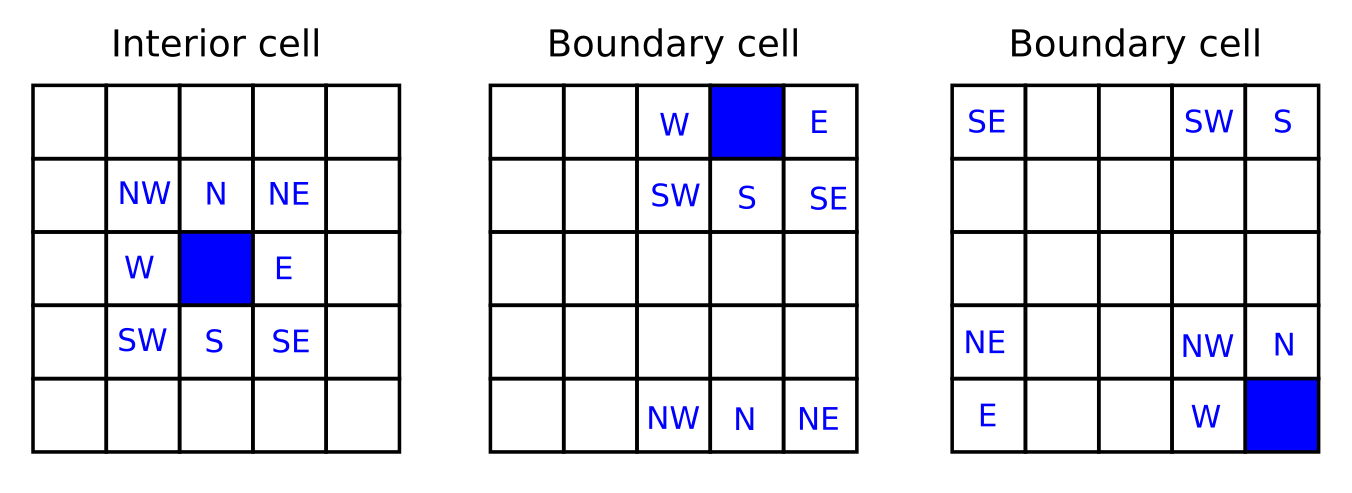
</div>

### Ghost cells

A convenient way to implement the periodic boundary conditions is by using *ghost* cells (also known as *halo* cells).  Ghost cells are an extra layer of cells that surrounds the original grid. With this trick, the cells that were at the boundary are now interior and we can find their neighbors in the standard way. Ghost cells are represented in red in the following figure. There are other ways to impose the periodic boundary conditions, but ghost cells will be needed anyway for the parallel implementation. That's why we adopt them here.



 <div>
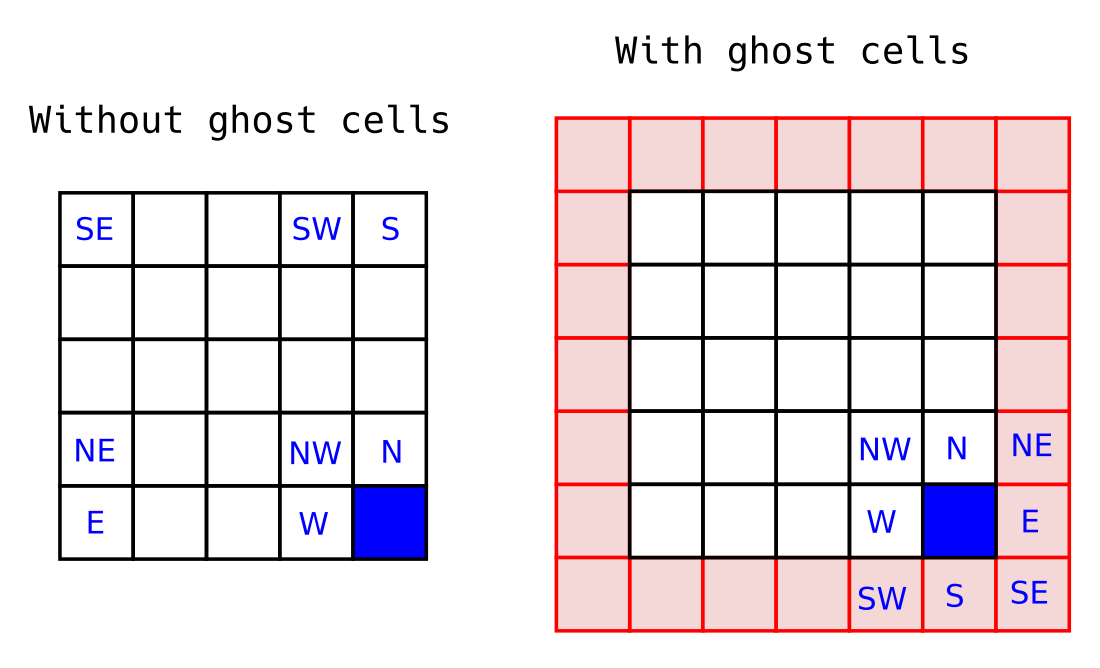
</div>


### Ghost cell update

When using ghost cells, one needs to keep their state consistent with the state of the corresponding non-ghost cell at the other end of the array. In practice, the values of ghost cells are updated at each simulation step before applying the rules.

## Serial implementation

Let's allocate a matrix that will represent the states of the cells. Note that we add two extra rows and columns for the ghost ones. 


In [1]:
m = 8
n = 10
a = Matrix{Int}(undef,m+2,n+2)

10×12 Matrix{Int64}:
   2683974747536  140729011978960  …  140729011978960  140729011978960
               0                1                   1                1
 140729011972720  140729011978960     140729011978960  140729011978960
               0                1                   1                1
   2683977502752  140729011978960     140729011978960  140729011978960
               0                1  …                1                1
   2683946237136  140729011978960     140729011978960  140729011978960
               0                1                   1                1
   2683982340688  140729011978960     140729011978960  140729011978960
               0                1                   1                1

### Inital state

The values of the matrix need to be initialized. The matrix will contain values  0 or 1, indicating that the cell is dead or live respectively.   As the initial state, we can use any of the patterns available [here](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life). We use a *glider* pattern in particular.

In [2]:
glider() = [(1,3),(2,3),(3,3),(2,1),(3,2)]

glider (generic function with 1 method)

Previous function returns the coordinates of the live cells in the grid. The next function is used to initialize the values of the matrix.

In [3]:
function init!(coords,a,rows,cols)
  a .= 0
  for (gi,gj) in coords
    if gi in rows && gj in cols
        i = searchsortedfirst(rows,gi)
        j = searchsortedfirst(cols,gj)
        a[i+1,j+1] = 1
    end
  end
  a
end

init! (generic function with 1 method)

The next code initializes the matrix using the glider pattern. Other functions can be passed in the first argument to build other patterns.

In [4]:
init!(glider(),a,1:m,1:n)

10×12 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  0  0  0  0  0
 0  0  1  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0

### Visualization

In order to better visualize the cell states, we introduce the next function.

In [5]:
] add Plots

    Updating registry at `C:\Users\orzma\.julia\registries\General.toml`
   Resolving package versions...
   Installed Wayland_protocols_jll ─ v1.31.0+0
   Installed GR_jll ──────────────── v0.71.8+0
   Installed JpegTurbo_jll ───────── v3.0.1+0
   Installed XML2_jll ────────────── v2.12.2+0
   Installed Scratch ─────────────── v1.2.1
   Installed Qt5Base_jll ─────────── v5.15.3+2
   Installed Latexify ────────────── v0.15.21
   Installed Preferences ─────────── v1.4.1
   Installed BitFlags ────────────── v0.1.8
   Installed Plots ───────────────── v1.38.0
   Installed Bzip2_jll ───────────── v1.0.8+1
   Installed Parsers ─────────────── v2.8.1
   Installed LLVMOpenMP_jll ──────── v15.0.7+0
   Installed Libtiff_jll ─────────── v4.4.0+0
   Installed ConcurrentUtilities ─── v2.3.0
   Installed PlotUtils ───────────── v1.4.0
   Installed OrderedCollections ──── v1.6.3
   Installed TranscodingStreams ──── v0.10.2
   Installed LaTeXStrings ────────── v1.3.1
   Installed fzf_jll ────────────

        Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated -m`
Precompiling project...
  ✓ LaTeXStrings
  ✓ BitFlags
  ✓ Compat
  ✓ OrderedCollections
  ✓ ClusterManagers
  ✓ Scratch
  ✓ ExceptionUnwrapping
  ✓ ConcurrentUtilities
  ✓ TranscodingStreams
  ✓ Preferences
  ✓ Compat → CompatLinearAlgebraExt
  ✓ RelocatableFolders
  ✓ MbedTLS
  ✓ TranscodingStreams → TestExt
  ✓ MacroTools
  ✓ SnoopPrecompile
  ✓ PrecompileTools
  ✓ JLLWrappers
  ✓ CodecZlib
  ✓ DataStructures
  ✓ fzf_jll
  ✓ RecipesBase
  ✓ Latexify
  ✓ OpenSSL_jll
  ✓ Opus_jll
  ✓ JpegTurbo_jll
  ✓ Ogg_jll
  ✓ Xorg_libXau_jll
  ✓ Xorg_xtrans_jll
  ✓ Xorg_libXdmcp_jll
  ✓ libpng_jll
  ✓ ColorSchemes
  ✓ x265_jll
  ✓ libfdk_aac_jll
  ✓ x264_jll
  ✓ Graphite2_jll
  ✓ Zstd_jll
  ✓ Libmount_jll
  ✓ libaom_jll
  ✓ Libiconv_jll
  ✓ LLVMOpenMP_jll
  ✓ Libffi_jll
  ✓ EpollShim_jll
  ✓ Expat_jll
  ✓ Bzip2_jll


In [6]:
using Plots

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots C:\Users\orzma\.julia\packages\Plots\M4dfL\src\backends.jl:37
[ Info: GR


In [7]:
function plot_state(a;kwargs...)
    m,n = size(a)
    plt = plot(;framestyle=:box)
    yflip = true
    xmirror=true
    colorbar=:none
    c=palette(:blues,2)
    heatmap!(1:n,1:m,a;yflip,colorbar,c,xmirror,kwargs...)
    plt
end

plot_state (generic function with 1 method)

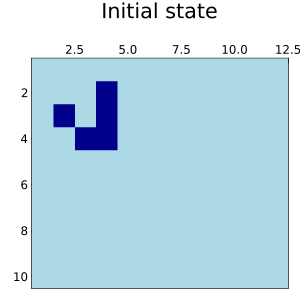

In [8]:
plot_state(a,title="Initial state",size=(300,300))

 Live and dead cells are represented with dark and light blue respectively in the generated figure.
 
 ### Implementation of the rules
 
 The following function implements the rules of the game. It computes the new state for the cell in row `i` and column `j` from matrix `a` that contain the states of all cells.

In [9]:
function rules(a,i,j)
    X = a[i,j]
    N = a[i+0,j-1]
    S = a[i+0,j+1]
    E = a[i+1,j+0]
    W = a[i-1,j+0]
    NE = a[i+1,j-1]
    NW = a[i-1,j-1]
    SE = a[i+1,j+1]
    SW = a[i-1,j+1]
    n_live_neigs = N+S+E+W+NE+NW+SE+SW
    if n_live_neigs == 3
        return 1
    elseif n_live_neigs == 2
        return Int(X)
    else
        return 0
    end

end

rules (generic function with 1 method)

### Grid update

Finally we need a function that updates the states of all cells. The new state needs to be stored in a separate array otherwise we will overwrite values that are not yet used. Note that we only update the value of the actual cells and not the ghost ones.

In [10]:
function update!(a_new,a)
    for j in 2:(size(a,2)-1)
        for i in 2:(size(a,1)-1)
            a_new[i,j] = rules(a,i,j)
        end
    end
end

update! (generic function with 1 method)

Use it to update the states:

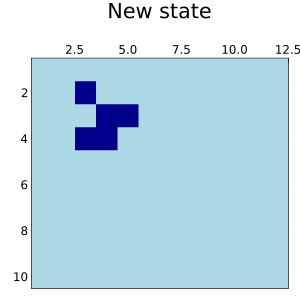

In [11]:
a_new = copy(a)
update!(a_new,a)
plot_state(a_new,title="New state",size=(300,300))

### The complete simulation

In summary, the following code updates the states for several time steps and generates an animation of the result.

[ Info: Saved animation to C:\Users\orzma\OneDrive\文件\ppp-assignment-2024-gol-julia\a1.gif


Plots.AnimatedGif("C:\\Users\\orzma\\OneDrive\\文件\\ppp-assignment-2024-gol-julia\\a1.gif")
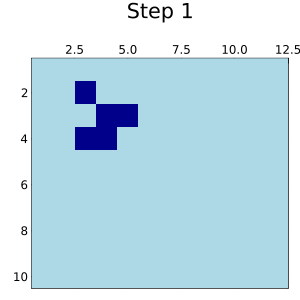

In [12]:
nsteps = 100
m = 8
n = 10
a = Matrix{Int}(undef,m+2,n+2)
init!(glider(),a,1:m,1:n)
a_new = copy(a)
anim = @animate for istep in 1:nsteps
    update!(a_new,a)
    a .= a_new
    plot_state(a;title="Step $istep",size=(300,300))
end
gif(anim,"a1.gif",fps=10)

Note that the glider is not able to pass through the boundary and gets stuck for the last time steps. This is because we have not updated the values of the ghost cells.

### Exercise 1

Implement the update of the ghost cells in the function below. We include the following figure again since it is useful to do the exercise. You have the solution at the end of the notebook, but try to do the exercise yourself.

 <div>
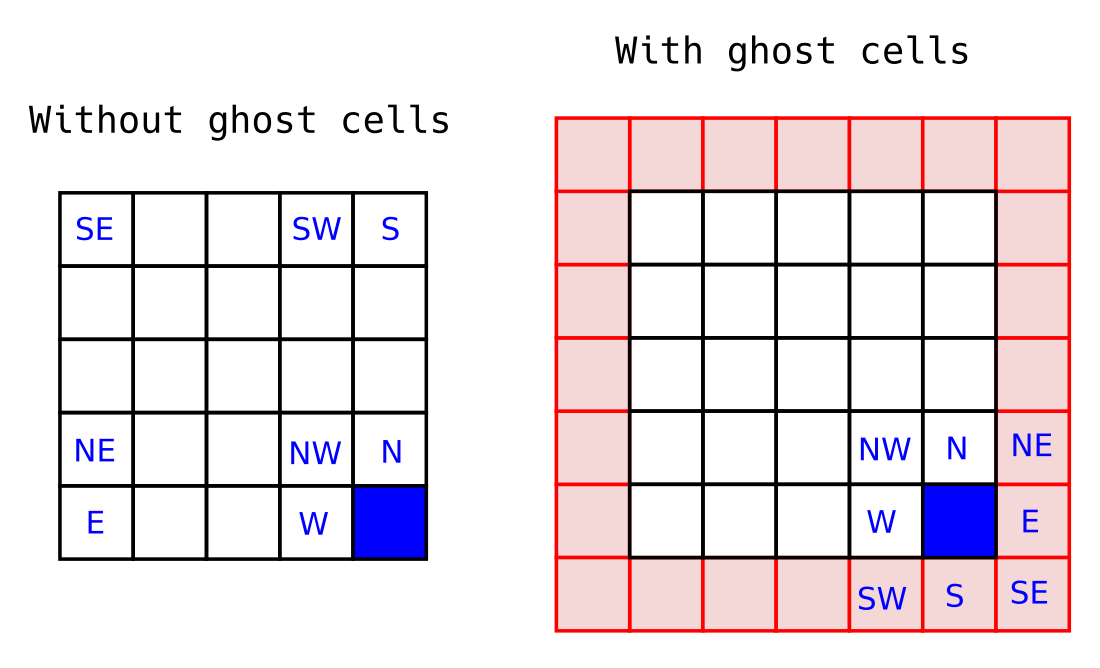
</div>

In [13]:
function update_ghost!(a)
    # Set the ghost positions in `a`
    # witht the values of the corresponding
    # non-ghost positions in `a`
    m, n = size(a)
    a[1, :] = a[m-1, :]
    a[m, :] = a[2, :]
    a[:, 1] = a[:, n-1]
    a[:, n] = a[:, 2]
end


function update_ghost!(a)
    m,n = size(a)
    for i in 2:(m-1)
        a[i,1] = a[i,end-1]
        a[i,end] = a[i,2]
    end
    for j in 2:(n-1)
        a[1,j] = a[end-1,j]
        a[end,j] = a[2,j]
    end
    a[1,1] = a[end-1,end-1]
    a[1,end] = a[end-1,2]
    a[end,1] = a[2,end-1]
    a[end,end] = a[2,2]
    a
end


update_ghost! (generic function with 1 method)

Once this function is properly implemented, the next code should generate the correct results with a glider able to pass through the boundary.

[ Info: Saved animation to C:\Users\orzma\OneDrive\文件\ppp-assignment-2024-gol-julia\a2.gif


Plots.AnimatedGif("C:\\Users\\orzma\\OneDrive\\文件\\ppp-assignment-2024-gol-julia\\a2.gif")
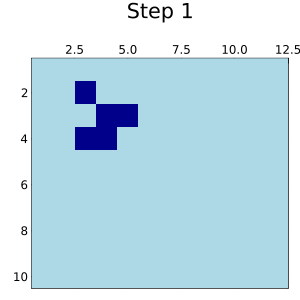

In [14]:
nsteps = 100
m = 8
n = 10
a = Matrix{Int}(undef,m+2,n+2)
init!(glider(),a,1:m,1:n)
a_new = copy(a)
anim = @animate for istep in 1:nsteps
    update_ghost!(a)
    update!(a_new,a)
    a .= a_new
    plot_state(a;title="Step $istep",size=(300,300))
end
gif(anim,"a2.gif",fps=10)

### A larger example

Let's compute a larger example with a different initialization function.

In [15]:
function gun()
  [
    (5, 1), (5, 2),
    (6, 1), (6, 2),
    (3,13), (3,14),
    (4,12), (4,16),
    (5,11), (5,17),
    (6,11), (6,15),
    (6,17), (6,18),
    (7,11), (7,17),
    (8,12), (8,16),
    (9,13), (9,14),
    (1,25), (7,25),
    (2,23), (2,25),
    (3,21), (3,22),
    (4,21), (4,22),
    (5,21), (5,22),
    (6,23), (6,25),
    (3,35), (3,36),
    (4,35), (4,36)
   ]
end


gun (generic function with 1 method)

[ Info: Saved animation to C:\Users\orzma\OneDrive\文件\ppp-assignment-2024-gol-julia\a3.gif


Plots.AnimatedGif("C:\\Users\\orzma\\OneDrive\\文件\\ppp-assignment-2024-gol-julia\\a3.gif")
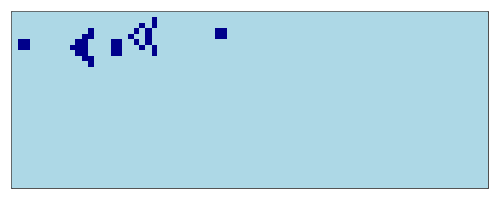

In [16]:
nsteps = 500
m = 30
n = 80
a = Matrix{Int}(undef,m+2,n+2)
init!(gun(),a,1:m,1:n)
a_new = copy(a)
anim = @animate for istep in 1:nsteps
    update_ghost!(a)
    update!(a_new,a)
    a .= a_new
    plot_state(a;size=(500,200),axis=nothing)
end
gif(anim,"a3.gif",fps=10)

### Exercise 2 (optional)

Create an even more interesting animation by using a different initial pattern. You can take inspiration from [here](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life). You can save it in GIF or MP4 format by using .gif or .mp4 in the file name extension.


## Parallel implementation

The basic idea of the parallel implementation is simple: we consider a block partition of the grid. Each worker will update the cells of its portion of the grid in parallel. In the assignment, `M` is the number of workers used to partition the rows and `N` is the number of workers used partition the columns. Thus, the total number of workers will be `M*N`. Note also that it is useful to identify the workers from their block coordinates.


 <div>
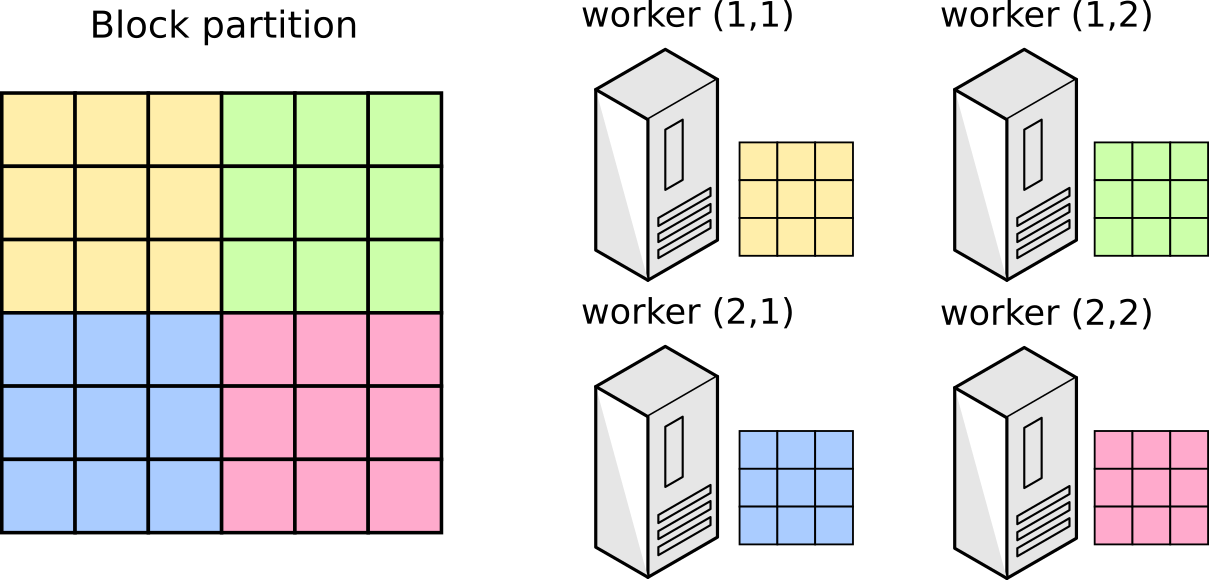
</div>

### Data dependencies

Workers require values stored at neighboring workers in order to update cells at the boundary of its portion of the grid. Getting these values requires to perform some communications. In order to store the values received from the other workers, we will use a ghost layer around the portion of the grid that each worker owns. Once the ghost layer has the right values, a worker can update the state of its own cells (i.e., the non ghost ones) in serial. From the workers perspective, the main difference between the serial and parallel implementations is that the parallel one needs a different way of updating the ghost cells (using communications). 


 <div>
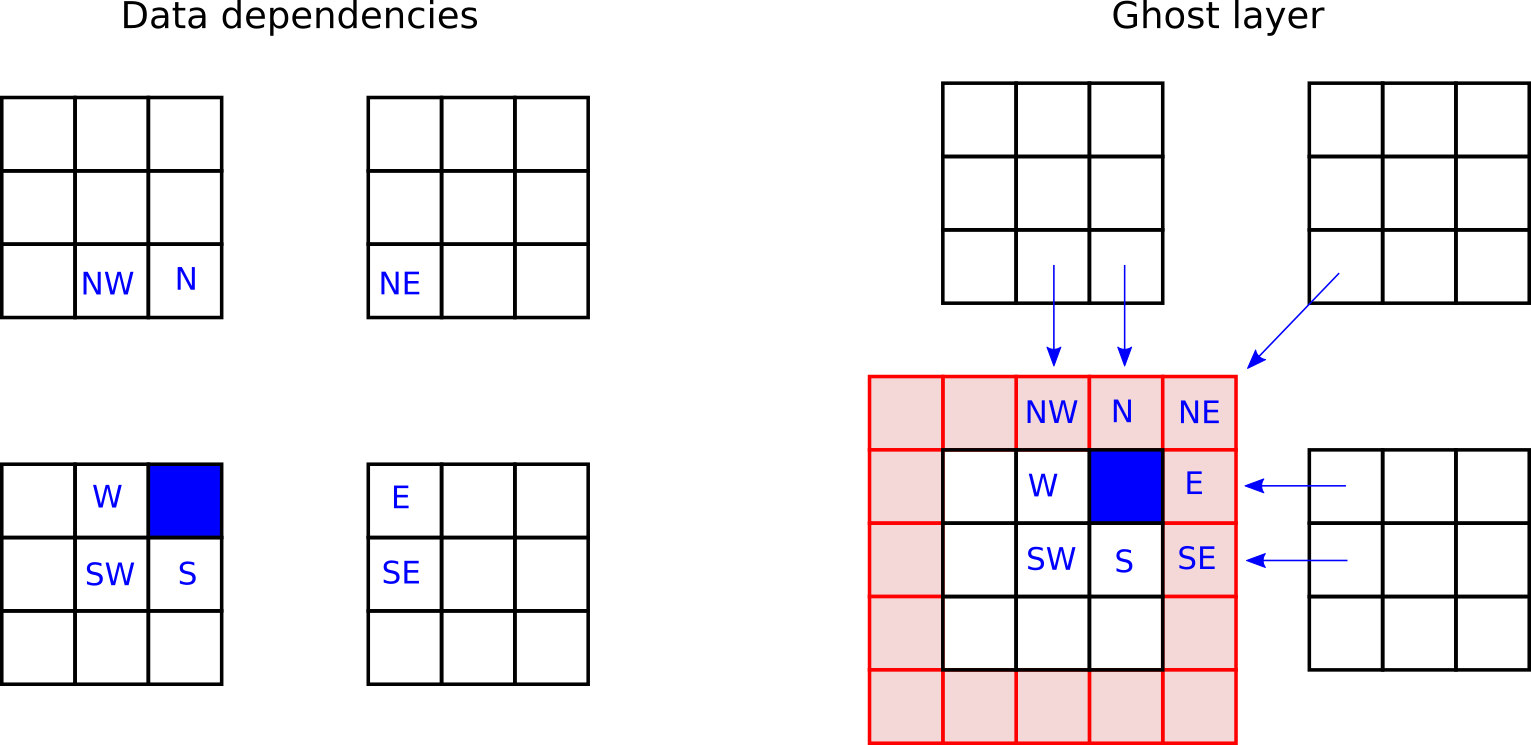
</div>

### Remote channels

In order to perform the communications we will use Julia remote channels. Each worker needs to receive and send data from/to 8 neigbour workers. Thus, we need 8 remote channels for sending and 8 remote channels for receiving this data. At a given worker, we group the channels for sending and receiving data in `chnls_snd` and `chnls_rcv` respectively. They are  3-by-3 matrices of remote channels. Channels are organized in these matrices as follows. If the current worker has block coordinates `(i,j)` and we want to send data to worker with block coordinates`(i+r,j+c)` (being `r` and `c` either 1 or -1), we will use the channel in `chnls_snd[2+r,2+c]`. Idem for `chnls_rcv`. For example, the worker situated at the east of the  one at  `(i,j)`  will have block coordinates `(i+0,j+1)`, thus the channels to send and receive data to/from this worker will be `chnls_snd[2+0,2+1]` and `chnls_rcv[2+0,2+1]` respectively (see figure below). The channels `chnls_snd[2,2]` and `chnls_rcv[2,2]` will be unused.

 <div>
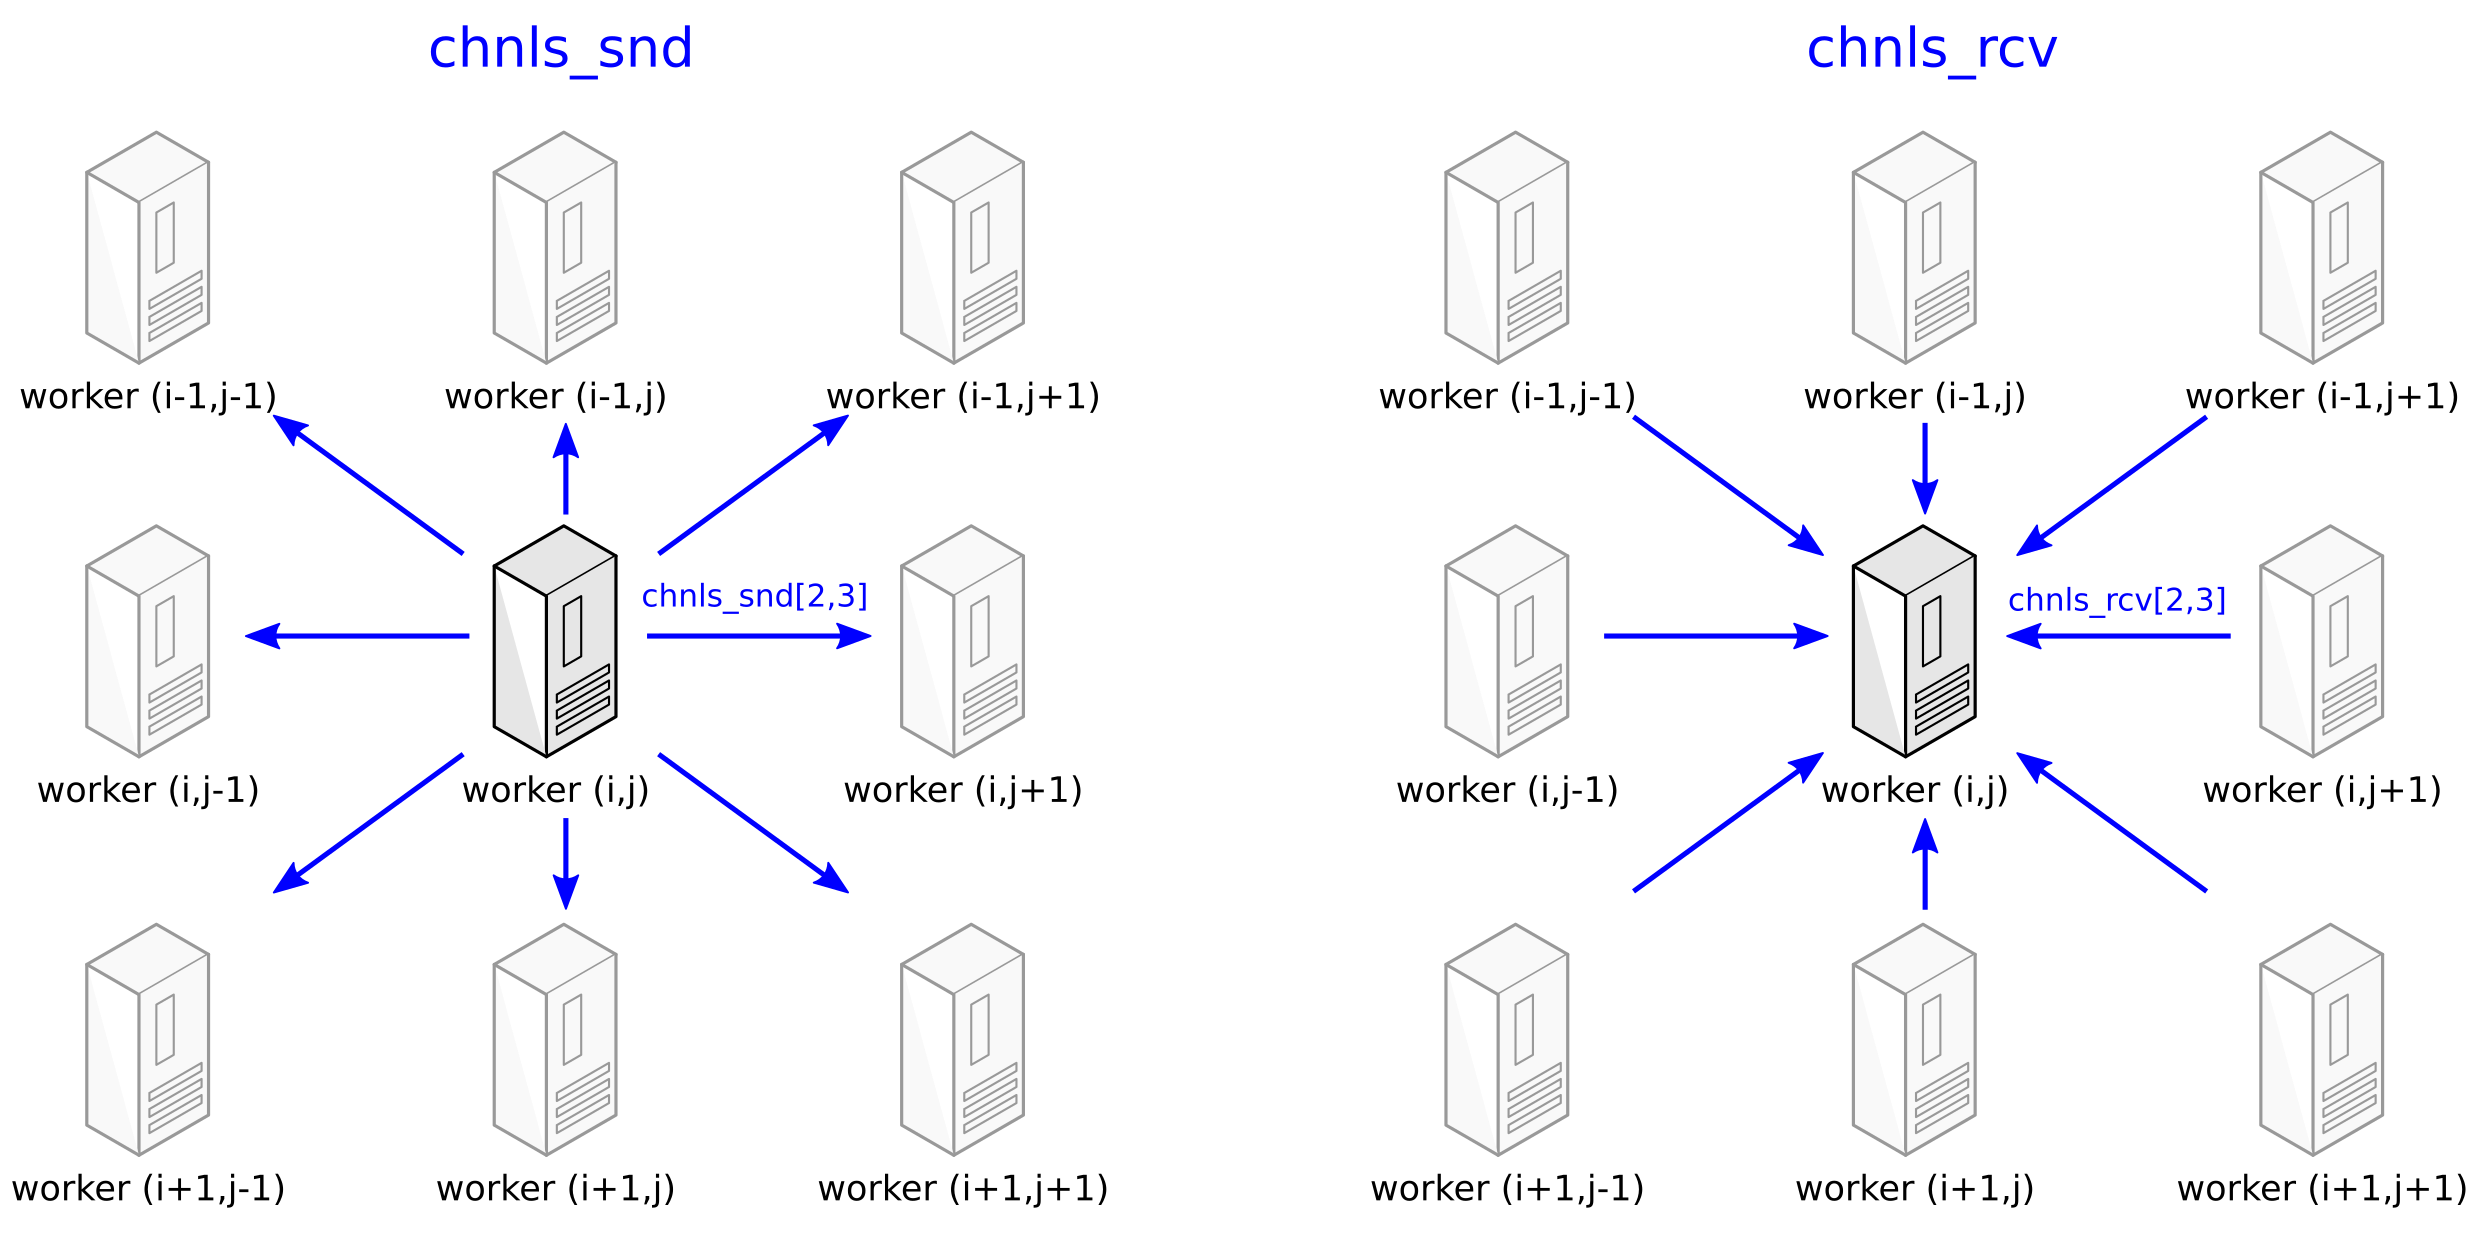
</div>

### The create_chnls_snd_and_rcv function

This is the first function to implement in the assignment. Its signature is

```
chnls_snd, chnls_rcv = create_chnls_snd_and_rcv(M,N,I,J,ftrs_chnls)
```

`M` and `N` are the number of workers in row and column directions and `(I,J)` is the block coordinates of the current worker. The variable `ftrs_chnls` is an `M`-by-`N` matrix of futures, e.g. there is a future for each worker. If we fetch one of these futures, we get the matrix `chnls_rcv` for the corresponding worker. In particular, `fetch(ftrs_chnls[I,J])` are the receiving channels `chnls_rcv` for the current worker. Building the sending channels `chnls_snd` for the current worker is a bit more challenging and it is what you need to implement in this function. The function should return `chnls_snd` and `chnls_rcv` for the current worker.

In [ ]:
function create_chnls_snd_and_rcv(M, N, I, J, ftrs_chnls)
    chnls_snd = Matrix{RemoteChannel}(undef, 3, 3)
    chnls_rcv = fetch(ftrs_chnls[I, J])

    for r in -1:1
        for c in -1:1
            if r == 0 && c == 0
                continue
            end
            i = I + r
            j = J + c
            if i < 1 || i > M || j < 1 || j > N
                chnls_snd[r + 2, c + 2] = RemoteChannel(()->nothing)
            else
                chnls_snd[r + 2, c + 2] = fetch(ftrs_chnls[i, j])
            end
        end
    end

    return chnls_snd, chnls_rcv
end

### The step_worker! function

This is the second function to implement. Its signature is

```
step_worker!(a_new,a,chnls_snd,chnls_rcv)
```

`a` is the local matrix containing the state of the cells in this worker before the time step. `a_new` is a matrix of the same size as `a` to temporarily store the new state at the end of the step. At the end of the function, the values of `a` new to be updated with the values of `a_new`. Note that these matrices include the layer of ghost cells. Inputs `chnls_snd` and `chnls_rcv` are the 3-by-3 matrices containing the channels for sending and receiving data. In order to implement function `step_worker!`, you will be able to reuse some parts of its serial counterpart `step_serial!` also provided in `solution.jl`.

## Solution of exercise 1

In [ ]:
function update_ghost!(a)
    m,n = size(a)
    for i in 2:(m-1)
        a[i,1] = a[i,end-1]
        a[i,end] = a[i,2]
    end
    for j in 2:(n-1)
        a[1,j] = a[end-1,j]
        a[end,j] = a[2,j]
    end
    a[1,1] = a[end-1,end-1]
    a[1,end] = a[end-1,2]
    a[end,1] = a[2,end-1]
    a[end,end] = a[2,2]
    a
end


In [ ]:
//

In [1]:
using Distributed
using Plots
using JSON

glider() = [(1,3),(2,3),(3,3),(2,1),(3,2)]

function gun()
    [
     (5, 1), (5, 2),
     (6, 1), (6, 2),
     (3,13), (3,14),
     (4,12), (4,16),
     (5,11), (5,17),
     (6,11), (6,15),
     (6,17), (6,18),
     (7,11), (7,17),
     (8,12), (8,16),
     (9,13), (9,14),
     (1,25), (7,25),
     (2,23), (2,25),
     (3,21), (3,22),
     (4,21), (4,22),
     (5,21), (5,22),
     (6,23), (6,25),
     (3,35), (3,36),
     (4,35), (4,36)
    ]
end

# This one is a periodic pattern
function beacon()
    [
     (1,1),(1,2),(2,1),
     (3,4),(4,3),(4,4),
    ]
end

# this one is static
function block()
    [(2,2),(2,3),(3,2),(3,3)]
end

function game_serial(init_fun,m,n,steps,worldstep,irun=1)
    params = (;init_fun,m,n,steps,worldstep,irun)
    fn = "serial_$(nameof(init_fun))_$(m)_$(n)_$(steps)_$(worldstep)_run_$irun"
    if worldstep == 0 # No animation
        game_serial_impl(nothing,fn,params)
    else # Animation
        # we follow a producer-consumer model to generate the animation
        # Note that this is a regular channel, not a remote one
        chnl_anim = Channel{Matrix{Int32}}()
        t = @async begin
            # The game of life is the producer
            try
                game_serial_impl(chnl_anim,fn,params)
            finally
                close(chnl_anim)
            end
        end
        # This loop consumes chnl_anim to generate the animation
        anim = @animate for a_anim in chnl_anim
            plot_state(a_anim)
        end
        wait(t)
        gif(anim,fn*".gif",fps=25)
    end
end

function game_serial_impl(chnl_anim,fn,params)
    (;init_fun,m,n,steps,worldstep,irun) = params
    a = Matrix{Int32}(undef,m+2,n+2)
    initial_coords = init_fun()
    init!(initial_coords,a,1:m,1:n)
    a_new = similar(a)
    a_history = [similar(a),similar(a)]
    final_step = steps
    wall_time = time()
    for istep in 1:steps
        step_serial!(a_new,a)
        tmp = a
        a = a_new
        a_new = a_history[2]
        a_history[2] = a_history[1]
        a_history[1] = tmp
        if worldstep != 0 && (istep % worldstep) == 0
            put!(chnl_anim,a[2:end-1,2:end-1])
        end
        if has_cycled(a,a_history,istep)
            final_step = istep
            break
        end
    end
    wall_time = time()-wall_time
    dict = Dict{Symbol,Any}()
    dict[:m] = m
    dict[:n] = n
    dict[:steps] = steps
    dict[:worldstep] = worldstep
    dict[:irun] = irun
    dict[:init_fun] = nameof(init_fun)
    dict[:wall_time] = wall_time
    dict[:final_step] = final_step
    print_results(dict)
    fn_json = fn*".json"
    open(fn_json,"w") do f
        JSON.print(f,dict) 
    end
    @info "Results file has been generated: $fn_json"
end

function print_results(dict)
    println("Results")
    for (k,v) in sort(collect(dict), by = x->x[1])
        println("    ",k,": ",v)
        end
end

function plot_state(a;kwargs...)
    m,n = size(a)
    plt = plot(;framestyle=:box)
    yflip = true
    xmirror=true
    colorbar=:none
    c=palette(:blues,2)
    heatmap!(1:n,1:m,a;yflip,colorbar,c,xmirror,kwargs...)
    plt
end

function init!(coords,a,rows,cols)
    a .= 0
    for (gi,gj) in coords
        if gi in rows && gj in cols
            i = searchsortedfirst(rows,gi)
            j = searchsortedfirst(cols,gj)
            a[i+1,j+1] = 1
        end
    end
    a
end

function step_serial!(a_new,a)
    update_ghost_serial!(a)
    update!(a_new,a)
end

function update_ghost_serial!(a)
    m,n = size(a)
    for i in 2:(m-1)
        a[i,1] = a[i,end-1]
        a[i,end] = a[i,2]
    end
    for j in 2:(n-1)
        a[1,j] = a[end-1,j]
        a[end,j] = a[2,j]
    end
    a[1,1] = a[end-1,end-1]
    a[1,end] = a[end-1,2]
    a[end,1] = a[2,end-1]
    a[end,end] = a[2,2]
    a
end

function update!(a_new,a)
    @inbounds for j in 2:(size(a,2)-1)
        for i in 2:(size(a,1)-1)
            a_new[i,j] = rules(a,i,j)
        end
    end
end

Base.@propagate_inbounds function rules(a,i,j)
    X = a[i,j]
    N = a[i+0,j-1]
    S = a[i+0,j+1]
    E = a[i+1,j+0]
    W = a[i-1,j+0]
    NE = a[i+1,j-1]
    NW = a[i-1,j-1]
    SE = a[i+1,j+1]
    SW = a[i-1,j+1]
    n_live_neigs = N+S+E+W+NE+NW+SE+SW
    if n_live_neigs == 3
        return Int32(1)
    elseif n_live_neigs == 2
        return Int32(X)
    else
        return Int32(0)
    end
end

function sum_interior_cells(a)
    s = zero(eltype(a))
    @inbounds for j in 2:(size(a,2)-1)
        for i in 2:(size(a,1)-1)
            s += a[i,j]
        end
    end
    s
end

function has_cycled(a,a_history,istep)
    r1 = interior_cells_are_equal(a,a_history[1])
    r1 || (istep>1 && interior_cells_are_equal(a,a_history[2]))
end

function interior_cells_are_equal(a,b)
    @inbounds for j in 2:(size(a,2)-1)
        for i in 2:(size(a,1)-1)
            if a[i,j] != b[i,j]
                return false
            end
        end
    end
    return true
end

function game_parallel(init_fun,m,n,M,N,nodes,steps,worldstep,irun=1)
    params = (;init_fun,m,n,M,N,nodes,steps,worldstep,irun)
        fn = "parallel_$(nameof(init_fun))_$(m)_$(n)_$(M)_$(N)_$(nodes)_$(steps)_$(worldstep)_run_$irun"
    if worldstep == 0 # No animation
        game_parallel_impl(nothing,fn,params)
    else # Animation
        # we follow a producer-consumer model to generate the animation
        # Note that this is a regular channel, not a remote one
        chnl_anim = Channel{Matrix{Int32}}()
        t = @async begin
            # The game of life is the producer
            try
                game_parallel_impl(chnl_anim,fn,params)
            finally
                close(chnl_anim)
            end
        end
        # This loop consumes chnl_anim to generate the animation
        anim = @animate for a_anim in chnl_anim
            plot_state(a_anim)
        end
        wait(t)
        gif(anim,fn*".gif",fps=25)
    end
end

function game_parallel_impl(chnl_anim,fn,params)
    (;init_fun,m,n,M,N,nodes,steps,worldstep,irun) = params
    check_input(m,n,M,N)
    ftrs_chnls = create_channels(M,N)
    chnl_world = RemoteChannel(()->Channel{Any}(1))
    channels = (;ftrs_chnls,chnl_world)
    ftrs_results = Matrix{Future}(undef,M,N)
    for J in 1:N
        for I in 1:M
            p = LinearIndices(ftrs_chnls)[I,J]
            w = workers()[p]
            ftrs_results[I,J] = @spawnat w begin
                game_worker(I,J,fn,params,channels)
            end
        end
    end
    final_step = steps
    for istep in 1:steps
        if worldstep != 0 && (istep % worldstep) == 0
            a = Matrix{Int32}(undef,m,n)
            for _ in 1:(M*N)
                my_a, my_rows, my_cols = take!(chnl_world)
                a[my_rows,my_cols] = my_a
            end
            put!(chnl_anim,a)
        end
    end
    wall_time = fetch.(ftrs_results[:])
    # print/output the results in JSON format
    dict = Dict{Symbol,Any}()
    dict[:m] = m
    dict[:n] = n
    dict[:M] = M
    dict[:N] = N
    dict[:nodes] = nodes
    dict[:steps] = steps
    dict[:worldstep] = worldstep
    dict[:wall_time] = wall_time
    dict[:final_step] = final_step
    dict[:irun] = irun
    dict[:init_fun] = nameof(init_fun)
    print_results(dict)
    fn_json = fn*".json"
    open(fn_json,"w") do f
        JSON.print(f,dict) 
    end
    @info "Results file has been generated: $fn_json"
end

function game_worker(I,J,fn,params,channels)
    (;init_fun,m,n,M,N,steps,worldstep) = params
    (;ftrs_chnls,chnl_world) = channels
    chnls_snd, chnls_rcv = create_chnls_snd_and_rcv(M,N,I,J,ftrs_chnls)
    my_rows = local_range(I,m,M)
    my_cols = local_range(J,n,N)
    my_m = length(my_rows)
    my_n = length(my_cols)
    a = Matrix{Int32}(undef,my_m+2,my_n+2)
    initial_coords = init_fun()
    init!(initial_coords,a,my_rows,my_cols)
    a_new = similar(a)
    a_history = [similar(a),similar(a)]
    wall_time = time()
    for istep in 1:steps
        step_worker!(a_new,a,chnls_snd,chnls_rcv)
        tmp = a
        a = a_new
        a_new = a_history[2]
        a_history[2] = a_history[1]
        a_history[1] = tmp
        if worldstep != 0 && (istep % worldstep) == 0
            put!(chnl_world,(a[2:end-1,2:end-1],my_rows,my_cols))
        end
    end
    wall_time = time()-wall_time
    return wall_time
end

function check_input(m,n,M,N)
    if mod(m,M) != 0
        error("m=$m should be multiple of M=$M")
    end
    if mod(n,N) != 0
        error("n=$n should be multiple of N=$N")
    end
    if nworkers() < N*M
        error("Not enough workers. M*N=$(M*N) but nworkers()=$(nworkers())")
    end
end

function create_channels(M,N)
    ftrs_chnls = Matrix{Future}(undef,M,N)
    @sync for J in 1:N
        for I in 1:M
            p = LinearIndices(ftrs_chnls)[I,J]
            w = workers()[p]
            ftrs_chnls[I,J] = @spawnat w begin
                buffer = 10
                f = () -> Channel{Matrix{Int32}}(buffer)
                [RemoteChannel(f) for i in -1:1, j in -1:1]
            end
        end
    end
    ftrs_chnls
end

function local_range(p,n,np)
    @assert mod(n,np) == 0
    load = div(n,np)
    offset = load*(p-1)
    start = offset + 1
    stop = offset + load
    start:stop
end

function periodic(i,n)
    i < 1 && return n-i
    i > n && return i-n
    i
end

function create_chnls_snd_and_rcv(M, N, I, J, ftrs_chnls)
    chnls_rcv = fetch(ftrs_chnls[I, J])
    chnls_snd = similar(chnls_rcv)
    # Implement here
    for i in -1:1
        for j in -1:1
            if i != 0 || j != 0
                ni = periodic(I + i, M)
                nj = periodic(J + j, N)
                chnls_snd[i + 2, j + 2] = fetch(ftrs_chnls[ni, nj])[2, 2]
            end
        end
    end
    
    chnls_snd, chnls_rcv
end

function step_worker!(a_new, a, chnls_snd, chnls_rcv)
    # Implement here
    update_ghost_parallel!(a, chnls_snd)
    update!(a_new, a)
end

function update_ghost_parallel!(a, chnls_snd)
    # Send and receive ghost cells with neighboring workers
    for i in -1:1
        for j in -1:1
            # Skip the current worker's channel (0,0)
            if i != 0 || j != 0
                # Send ghost cells to the neighboring worker
                put!(chnls_snd[i + 2, j + 2], a[2:end-1, 2:end-1])

                # Receive ghost cells from the neighboring worker
                a[2:end-1, 2:end-1] .= take!(chnls_snd[i + 2, j + 2])
            end
        end
    end
end

function game_check(init_fun,m,n,M,N,nodes,steps,worldstep,irun=1)
    worldstep = 1
    params = (;init_fun,m,n,M,N,nodes,steps,worldstep,irun)
    chnl_serial = Channel{Matrix{Int32}}()
    t = @async begin
        try
            fn = "test_serial_$(nameof(init_fun))_$(m)_$(n)_$(steps)_$(worldstep)_run_$irun"
            game_serial_impl(chnl_serial,fn,params)
        finally
            close(chnl_serial)
        end
    end
    a_serial = [ copy(i) for i in chnl_serial ]
    wait(t)
    chnl_parallel = Channel{Matrix{Int32}}()
    t = @async begin
        try
            fn = "test_parallel_$(nameof(init_fun))_$(m)_$(n)_$(M)_$(N)_$(steps)_$(worldstep)_run_$irun"
            game_parallel_impl(chnl_parallel,fn,params)
        finally
            close(chnl_parallel)
        end
    end
    a_parallel = [ copy(i) for i in chnl_parallel ]
    wait(t)
    a_parallel == a_serial
end


[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
┌ Warning: backend `GR` is not installed.
└ @ Plots C:\Users\orzma\.julia\packages\Plots\M4dfL\src\backends.jl:37
[ Info: GR


game_check (generic function with 2 methods)